# **Redes Neurais**
## **Modelo 2 - Self-Organizing Maps (SOM)**

- Tales Miguel
- RA: 140247

- Professor Dr. Marcos G. Quiles

## **Instruções**
### **PROJETO 2 – APRENDIZADO NÃO-SUPERVISIONADO**


- Selecionar pelo menos dois datasets;

- Aplicar um modelo neural não supervisionado

- Avaliar os padrões detectados em cada conjunto:
  - Clusters / outliers, etc.

- Avaliar a homogeneidade dos agrupamentos

- Variar os parâmetros do modelo (grid, taxas, número de neurônios, etc.)

### **1. Datasets escolhidos**

#### **Dataset 1: MNIST (Dígitos Manuscritos)**
**Fonte**: `keras.datasets.mnist` | [Original: Yann LeCun](http://yann.lecun.com/exdb/mnist/)
- Ano: 1998
- Samples: 70.000 (60k treino + 10k teste)
- Features: 784 (28x28 pixels)
- Classes: 10 dígitos (0-9)
- **Objetivo**: Descobrir agrupamentos naturais de dígitos sem usar rótulos

#### **Dataset 2: California Housing (Dados Geográficos/Econômicos)**  
**Fonte**: `sklearn.datasets.fetch_california_housing` | [Census 1990](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)
- Ano: 1997
- Samples: 20.640
- Features: 8
    - MedInc - Median income in block group
    - HouseAge - Median house age in block group
    - AveRooms - Average number of rooms per household
    - AveBedrms - Average number of bedrooms per household
    - Population - Block group population
    - AveOccup - Average number of household members
    - Latitude - Block group latitude
    - Longitude - Block group longitude
- **Objetivo**: Identificar regiões com perfis socioeconômicos similares e outliers

### **2. Imports e Configuração**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

np.random.seed(42)
tf.random.set_seed(42)

2025-10-15 16:42:11.085655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 16:42:11.113098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 16:42:11.746969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 16:42:11.746969: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

## **3. Dataset 1 - MNIST**

### **3.1. Carregamento e Pré-processamento**
Carregamento do MNIST e normalização dos pixels (0-1). Para aprendizado não-supervisionado, utilizarei apenas os dados de treino (sem os rótulos para treinar a SOM).

In [2]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

X_mnist_full = np.concatenate([X_train_mnist, X_test_mnist], axis=0)
y_mnist_full = np.concatenate([y_train_mnist, y_test_mnist], axis=0)

X_mnist_flat = X_mnist_full.reshape(X_mnist_full.shape[0], -1).astype('float32') / 255.0
 
X_mnist_sample = X_mnist_flat[:10000]
y_mnist_sample = y_mnist_full[:10000]

print(f"Dataset completo MNIST: {X_mnist_flat.shape}")
print(f"Sample para SOM: {X_mnist_sample.shape}")
print(f"Pixel range: [{X_mnist_sample.min():.1f}, {X_mnist_sample.max():.1f}]")
print(f"Classes presentes: {np.unique(y_mnist_sample)}")

Dataset completo MNIST: (70000, 784)
Sample para SOM: (10000, 784)
Pixel range: [0.0, 1.0]
Classes presentes: [0 1 2 3 4 5 6 7 8 9]


### **3.2. Visualização dos Dados**
Análise visual de amostras dos dígitos e distribuição das classes.

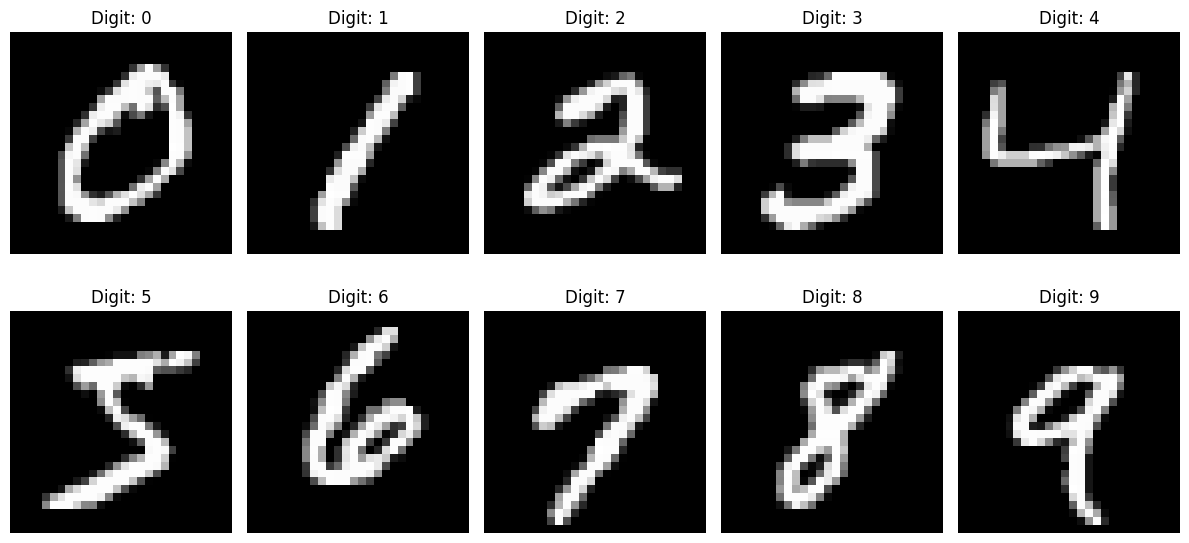

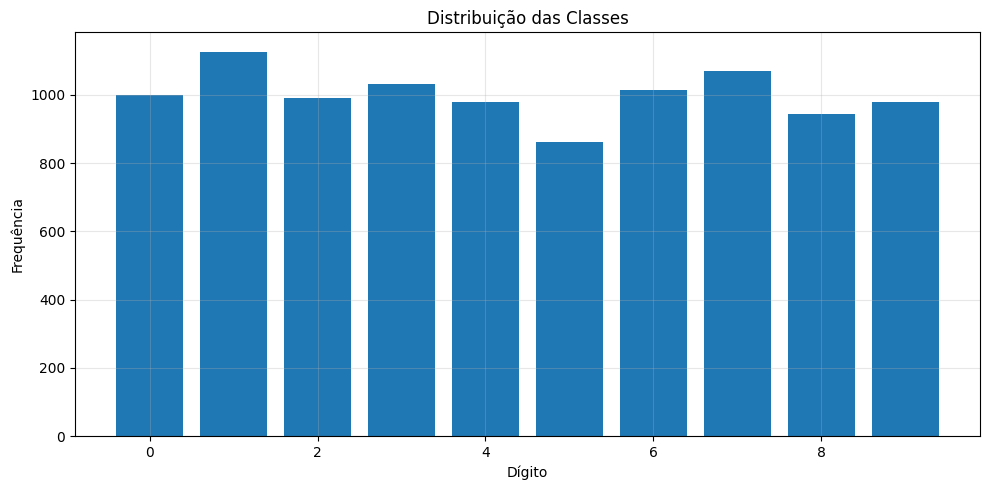

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = np.where(y_mnist_sample == i)[0][0]
    img = X_mnist_sample[idx].reshape(28, 28)
    axes[i//5, i%5].imshow(img, cmap='gray')
    axes[i//5, i%5].set_title(f'Digit: {i}')
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

unique, counts = np.unique(y_mnist_sample, return_counts=True)
ax.bar(unique, counts)
ax.set_title('Distribuição das Classes')
ax.set_xlabel('Dígito')
ax.set_ylabel('Frequência')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **3.3. Implementação da Self-Organizing Map (SOM)**
Implementação da rede SOM utilizando TensorFlow/NumPy para aproveitar aceleração por GPU.

In [4]:
class SOM:
    def __init__(self, grid_size, input_dim, learning_rate=0.5, sigma=None):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.initial_learning_rate = learning_rate
        self.learning_rate = learning_rate
        self.initial_sigma = sigma if sigma else max(grid_size) / 2.0
        self.sigma = self.initial_sigma
        
        self.weights = tf.Variable(
            tf.random.normal([grid_size[0], grid_size[1], input_dim], dtype=tf.float32),
            trainable=False
        )
        
        self.grid_x, self.grid_y = np.meshgrid(
            np.arange(grid_size[0]), 
            np.arange(grid_size[1])
        )
        self.grid_positions = np.stack([self.grid_x.ravel(), self.grid_y.ravel()], axis=1)
    
    def _find_bmu(self, input_vector):
        input_vector = tf.reshape(input_vector, [1, 1, self.input_dim])
        distances = tf.reduce_sum(tf.square(self.weights - input_vector), axis=2)
        bmu_index = tf.argmin(tf.reshape(distances, [-1]))
        bmu_x = bmu_index // self.grid_size[1]
        bmu_y = bmu_index % self.grid_size[1]
        return bmu_x.numpy(), bmu_y.numpy()
    
    def _calculate_influence(self, bmu_position, iteration, total_iterations):
        self.sigma = self.initial_sigma * np.exp(-iteration / (total_iterations / np.log(self.initial_sigma)))
        self.learning_rate = self.initial_learning_rate * np.exp(-iteration / total_iterations)
        
        distances = np.sum((self.grid_positions - bmu_position) ** 2, axis=1)
        influence = np.exp(-distances / (2 * self.sigma ** 2))
        influence = influence.reshape(self.grid_size[0], self.grid_size[1], 1)
        
        return tf.constant(influence, dtype=tf.float32)
    
    def train(self, data, num_iterations, verbose=True):
        total_samples = data.shape[0]
        
        for iteration in range(num_iterations):
            idx = np.random.randint(0, total_samples)
            input_vector = tf.constant(data[idx], dtype=tf.float32)
            
            bmu_x, bmu_y = self._find_bmu(input_vector)
            bmu_position = np.array([bmu_x, bmu_y])
            
            influence = self._calculate_influence(bmu_position, iteration, num_iterations)
            
            delta = self.learning_rate * influence * (input_vector - self.weights)
            self.weights.assign_add(delta)
            
            if verbose and (iteration + 1) % (num_iterations // 10) == 0:
                print(f"Iteration {iteration + 1}/{num_iterations} - LR: {self.learning_rate:.4f} - Sigma: {self.sigma:.4f}")
    
    def get_bmu_map(self, data):
        bmu_map = np.zeros((data.shape[0], 2), dtype=int)
        for i, sample in enumerate(data):
            bmu_x, bmu_y = self._find_bmu(tf.constant(sample, dtype=tf.float32))
            bmu_map[i] = [bmu_x, bmu_y]
        return bmu_map
    
    def calculate_u_matrix(self):
        u_matrix = np.zeros(self.grid_size)
        weights_np = self.weights.numpy()
        
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                neighbors = []
                if i > 0:
                    neighbors.append(weights_np[i-1, j])
                if i < self.grid_size[0] - 1:
                    neighbors.append(weights_np[i+1, j])
                if j > 0:
                    neighbors.append(weights_np[i, j-1])
                if j < self.grid_size[1] - 1:
                    neighbors.append(weights_np[i, j+1])
                
                if neighbors:
                    distances = [np.linalg.norm(weights_np[i, j] - neighbor) for neighbor in neighbors]
                    u_matrix[i, j] = np.mean(distances)
        
        return u_matrix


### **3.4. Configuração dos Experimentos**
Diferentes configurações de grid para avaliar o impacto na qualidade dos agrupamentos.

In [ ]:
som_configs = [
    {"name": "10x10", "grid_size": (10, 10), "learning_rate": 0.5, "iterations": 5000},
    {"name": "15x15", "grid_size": (15, 15), "learning_rate": 0.5, "iterations": 7500},
    {"name": "20x20", "grid_size": (20, 20), "learning_rate": 0.5, "iterations": 10000},
]

print("Configurações de SOM definidas:")
for i, config in enumerate(som_configs, 1):
    print(f"{i}. Grid {config['name']} - LR: {config['learning_rate']} - Iterations: {config['iterations']}")

Configurações de SOM definidas:
1. Grid 10x10 - LR: 0.5 - Iterations: 5000
2. Grid 15x15 - LR: 0.5 - Iterations: 7500
3. Grid 20x20 - LR: 0.5 - Iterations: 10000


### **3.5. Treinamento da SOM - Grid 10x10**
Treinamento inicial com grid 10x10 para análise detalhada.

In [6]:
import time

config = som_configs[0]
print(f"Treinando SOM - Grid {config['name']}")
print(f"Parâmetros: LR={config['learning_rate']}, Iterations={config['iterations']}")
print("-" * 60)

som_10x10 = SOM(
    grid_size=config['grid_size'],
    input_dim=X_mnist_sample.shape[1],
    learning_rate=config['learning_rate']
)

start_time = time.time()
som_10x10.train(X_mnist_sample, num_iterations=config['iterations'], verbose=True)
training_time = time.time() - start_time

print(f"\nTreinamento concluído em {training_time:.2f} segundos")

bmu_map_10x10 = som_10x10.get_bmu_map(X_mnist_sample)
print(f"BMU map calculado: {bmu_map_10x10.shape}")

Treinando SOM - Grid 10x10
Parâmetros: LR=0.5, Iterations=5000
------------------------------------------------------------


I0000 00:00:1760557332.467698   29333 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Iteration 500/5000 - LR: 0.4525 - Sigma: 4.2581
Iteration 1000/5000 - LR: 0.4094 - Sigma: 3.6251
Iteration 1000/5000 - LR: 0.4094 - Sigma: 3.6251
Iteration 1500/5000 - LR: 0.3705 - Sigma: 3.0862
Iteration 1500/5000 - LR: 0.3705 - Sigma: 3.0862
Iteration 2000/5000 - LR: 0.3352 - Sigma: 2.6274
Iteration 2000/5000 - LR: 0.3352 - Sigma: 2.6274
Iteration 2500/5000 - LR: 0.3033 - Sigma: 2.2368
Iteration 2500/5000 - LR: 0.3033 - Sigma: 2.2368
Iteration 3000/5000 - LR: 0.2745 - Sigma: 1.9043
Iteration 3000/5000 - LR: 0.2745 - Sigma: 1.9043
Iteration 3500/5000 - LR: 0.2483 - Sigma: 1.6212
Iteration 3500/5000 - LR: 0.2483 - Sigma: 1.6212
Iteration 4000/5000 - LR: 0.2247 - Sigma: 1.3802
Iteration 4000/5000 - LR: 0.2247 - Sigma: 1.3802
Iteration 4500/5000 - LR: 0.2033 - Sigma: 1.1750
Iteration 4500/5000 - LR: 0.2033 - Sigma: 1.1750
Iteration 5000/5000 - LR: 0.1840 - Sigma: 1.0003

Treinamento concluído em 3.88 segundos
Iteration 5000/5000 - LR: 0.1840 - Sigma: 1.0003

Treinamento concluído em 3.88

### **3.6. Heat Maps - Mapa de Ativação por Classe (dígito)**
Visualização de onde cada dígito é mapeado no grid da SOM.

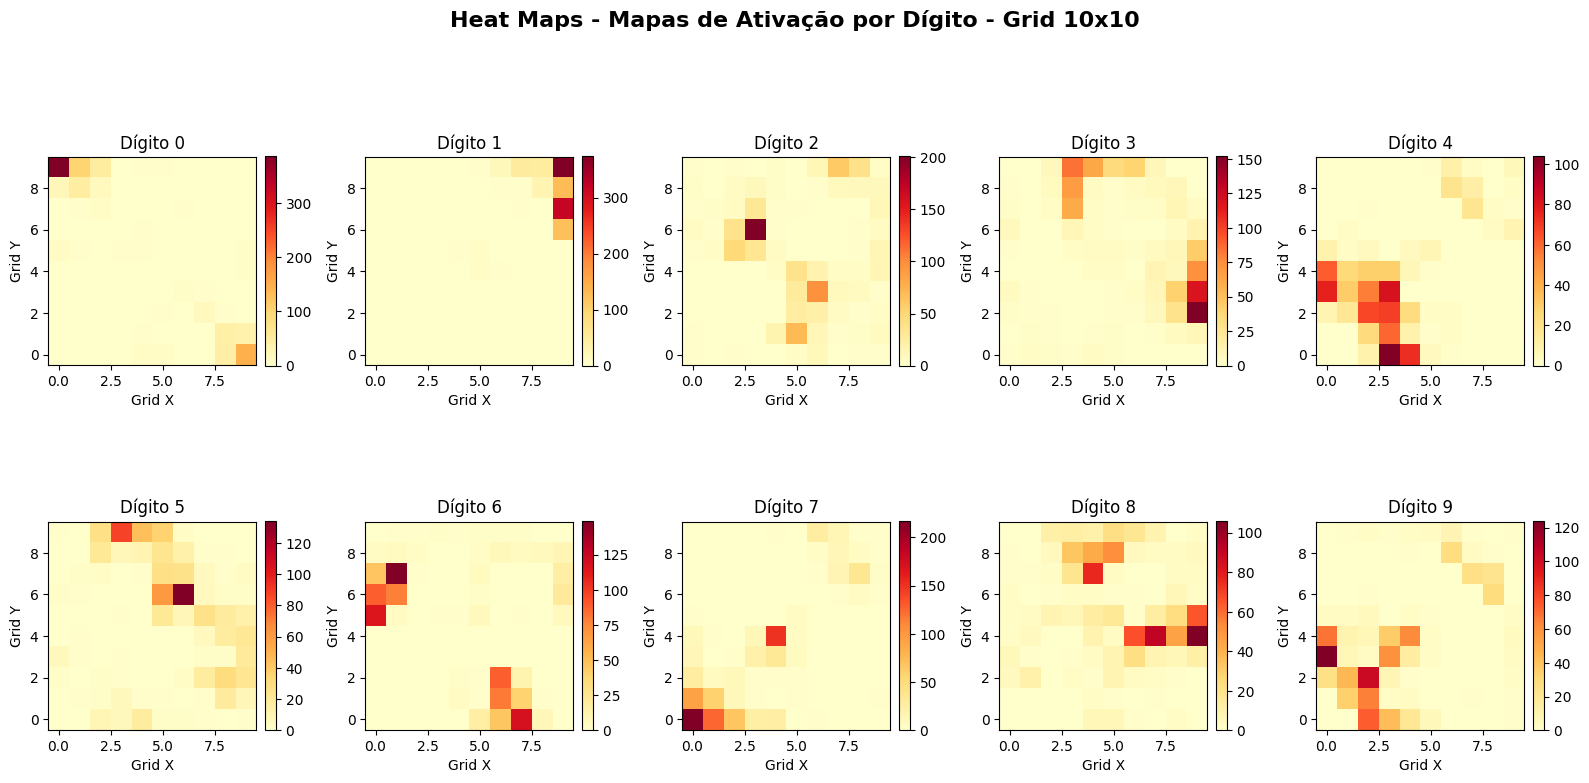

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

for digit in range(10):
    digit_mask = (y_mnist_sample == digit)
    digit_bmus = bmu_map_10x10[digit_mask]
    
    heatmap = np.zeros(som_10x10.grid_size)
    for bmu in digit_bmus:
        heatmap[bmu[0], bmu[1]] += 1
    
    im = axes[digit].imshow(heatmap, cmap='YlOrRd', interpolation='nearest', origin='lower')
    axes[digit].set_title(f'Dígito {digit}')
    axes[digit].set_xlabel('Grid X')
    axes[digit].set_ylabel('Grid Y')
    plt.colorbar(im, ax=axes[digit], fraction=0.046, pad=0.04)

plt.suptitle('Heat Maps - Mapas de Ativação por Dígito - Grid 10x10', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **3.7. Hits Map - Frequência de Ativação**
Visualização da frequência total de ativação de cada neurônio no grid, independente da classe.

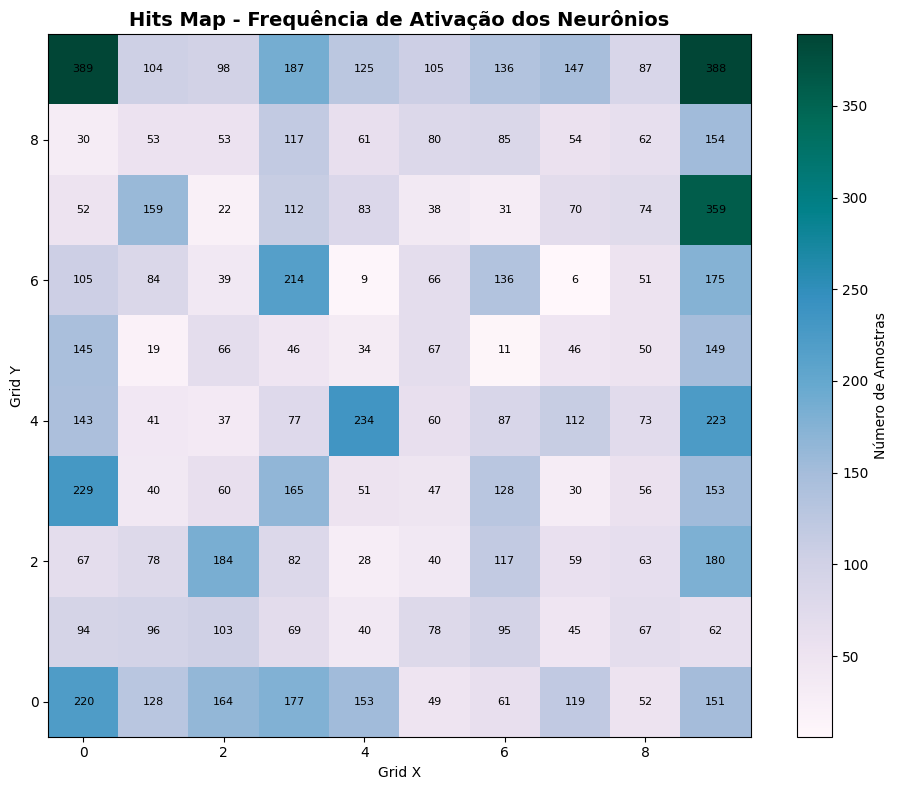

Total de amostras: 10000
Neurônios ativos: 100/100


In [8]:
hits_map = np.zeros(som_10x10.grid_size)

for bmu in bmu_map_10x10:
    hits_map[bmu[0], bmu[1]] += 1

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(hits_map, cmap='PuBuGn', interpolation='nearest', origin='lower')
ax.set_title('Hits Map - Frequência de Ativação dos Neurônios', fontsize=14, fontweight='bold')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')

for i in range(som_10x10.grid_size[0]):
    for j in range(som_10x10.grid_size[1]):
        text = ax.text(j, i, int(hits_map[i, j]),
                      ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax, label='Número de Amostras')
plt.tight_layout()
plt.show()

total_hits = np.sum(hits_map)
active_neurons = np.count_nonzero(hits_map)
print(f"Total de amostras: {int(total_hits)}")
print(f"Neurônios ativos: {active_neurons}/{som_10x10.grid_size[0] * som_10x10.grid_size[1]}")

### **3.8. U-Matrix - Distâncias entre Neurônios**
A U-Matrix mostra as distâncias (diferenças) entre neurônios vizinhos, revelando a estrutura de clusters no mapa.

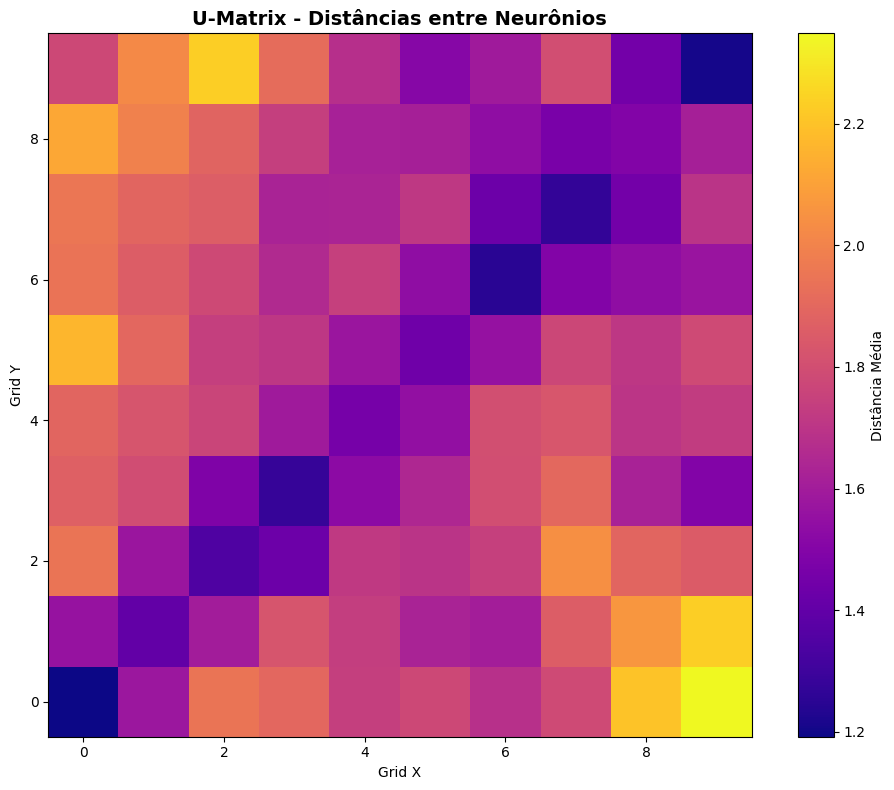

In [9]:
u_matrix = som_10x10.calculate_u_matrix()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(u_matrix, cmap='plasma', interpolation='nearest', origin='lower')
ax.set_title('U-Matrix - Distâncias entre Neurônios', fontsize=14, fontweight='bold')
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')
plt.colorbar(im, ax=ax, label='Distância Média')
plt.tight_layout()
plt.show()

### **3.9. Análise de Clusters**
Atribuição de clusters baseado nas posições BMU e cálculo de métricas de qualidade.

In [10]:
cluster_labels = bmu_map_10x10[:, 0] * som_10x10.grid_size[1] + bmu_map_10x10[:, 1]

silhouette = silhouette_score(X_mnist_sample, cluster_labels)
davies_bouldin = davies_bouldin_score(X_mnist_sample, cluster_labels)
calinski = calinski_harabasz_score(X_mnist_sample, cluster_labels)

print("Métricas de Qualidade dos Clusters - Grid 10x10:")
print(f"  Silhouette Score: {silhouette:.4f} (quanto maior, melhor)")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f} (quanto menor, melhor)")
print(f"  Calinski-Harabasz Score: {calinski:.2f} (quanto maior, melhor)")

unique_clusters = len(np.unique(cluster_labels))
print(f"\nNúmero de clusters únicos formados: {unique_clusters}")

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"Distribuição de amostras por cluster (top 10):")
print(cluster_counts.head(10))

Métricas de Qualidade dos Clusters - Grid 10x10:
  Silhouette Score: 0.0116 (quanto maior, melhor)
  Davies-Bouldin Index: 4.1817 (quanto menor, melhor)
  Calinski-Harabasz Score: 65.28 (quanto maior, melhor)

Número de clusters únicos formados: 100
Distribuição de amostras por cluster (top 10):
0    220
1    128
2    164
3    177
4    153
5     49
6     61
7    119
8     52
9    151
Name: count, dtype: int64


## **4. Dataset 2 - California Housing**

### **4.1. Carregamento e Pré-processamento**
Carregamento do California Housing dataset e normalização das features.

In [11]:
california_housing = fetch_california_housing()
X_housing = california_housing.data
y_housing = california_housing.target
feature_names = california_housing.feature_names

scaler_housing = StandardScaler()
X_housing_scaled = scaler_housing.fit_transform(X_housing)

print(f"Dataset shape: {X_housing_scaled.shape}")
print(f"Features: {feature_names}")
print(f"Features range após normalização: [{X_housing_scaled.min():.2f}, {X_housing_scaled.max():.2f}]")
print(f"Target range: [{y_housing.min():.2f}, {y_housing.max():.2f}]")

Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Features range após normalização: [-2.39, 119.42]
Target range: [0.15, 5.00]


### **4.2. Análise Exploratória dos Dados**
Visualização da distribuição das features e correlações.

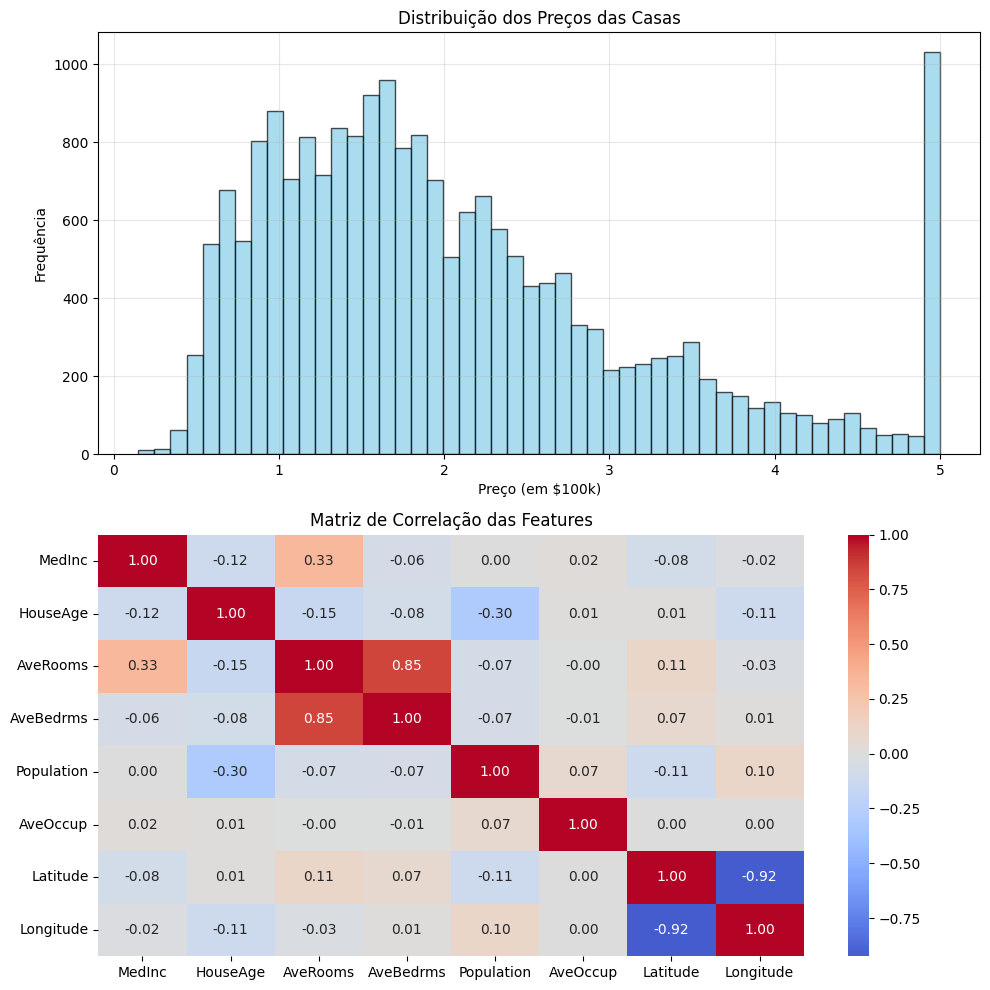


Estatísticas do dataset (após normalização):
      Feature  Mean  Std    Min      Max
0      MedInc   0.0  1.0 -1.774    5.858
1    HouseAge   0.0  1.0 -2.196    1.856
2    AveRooms   0.0  1.0 -1.852   55.163
3   AveBedrms  -0.0  1.0 -1.611   69.572
4  Population  -0.0  1.0 -1.256   30.250
5    AveOccup   0.0  1.0 -0.229  119.419
6    Latitude   0.0  1.0 -1.448    2.958
7   Longitude  -0.0  1.0 -2.386    2.625


In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.hist(y_housing, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribuição dos Preços das Casas')
ax1.set_xlabel('Preço (em $100k)')
ax1.set_ylabel('Frequência')
ax1.grid(True, alpha=0.3)

df_housing = pd.DataFrame(X_housing, columns=feature_names)
correlation_matrix = df_housing.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax2)
ax2.set_title('Matriz de Correlação das Features')

plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    'Feature': feature_names,
    'Mean': np.mean(X_housing_scaled, axis=0),
    'Std': np.std(X_housing_scaled, axis=0),
    'Min': np.min(X_housing_scaled, axis=0),
    'Max': np.max(X_housing_scaled, axis=0)
})

print("\nEstatísticas do dataset (após normalização):")
print(stats.round(3))